# <span style="background-color: darkgreen;">SAE : Mener une étude statistique dans un domaine d'application </span>



## <u>Projet</u>: Clustering probabiliste (London Bike Sharing Dataset)

<u> **Objectif du projet**</u> : L’objectif de ce projet est de construire un clustering probabiliste des stations du réseau London Bike Sharing, fondé sur les flux de trajets observés entre stations.

Pour ce faire, à partir des données de déplacements, nous construisons une matrice d’interactions directionnelles entre stations, représentant l’intensité des flux de mobilité. Cette matrice de comptage, de grande dimension et fortement clairsemée, est ensuite modélisée à l’aide d’un modèle probabiliste latent afin d’extraire, pour chaque station, une représentation latente de faible dimension résumant son rôle structurel dans le réseau de transport.

Enfin, ces représentations latentes sont utilisées comme entrée d’un modèle de clustering probabiliste, permettant d’identifier des groupes de stations partageant des profils de connectivité similaires. Les résultats sont analysés et visualisés afin d’interpréter la structure spatiale et fonctionnelle du réseau

### 1) Extraction et exploration des données

In [27]:
import pandas as pd

# Chargement des datasets
journeys = pd.read_csv('journeys.csv')
stations = pd.read_csv('stations.csv')

# Inspection de stations.csv
print("\nDimensions de stations.csv :", stations.shape)
print("Nombre unique d'ID de stations uniques :", stations['Station ID'].nunique())
print("Colonnes de stations :", stations.columns.tolist())


Dimensions de stations.csv : (773, 5)
Nombre unique d'ID de stations uniques : 773
Colonnes de stations : ['Station ID', 'Capacity', 'Latitude', 'Longitude', 'Station Name']


Au total, le jeu de données sur les stations contient 773 lignes (soit 773 stations de vélos) et 5 colonnes.

In [28]:
print("Aperçu des 5 premières lignes :\n")
stations.head()

Aperçu des 5 premières lignes :



,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


In [29]:
print("Valeurs manquantes :\n", stations.isnull().sum())

Valeurs manquantes :
 Station ID      0
Capacity        0
Latitude        0
Longitude       0
Station Name    0
dtype: int64


Aucune valeur manquante dans le dataset !!

In [30]:
# Inspection de journeys.csv
print("Dimensions de journeys.csv :", journeys.shape)  
print("Colonnes du jeu de données :", journeys.columns.tolist())

Dimensions de journeys.csv : (1542844, 14)
Colonnes du jeu de données : ['Journey Duration', 'Journey ID', 'End Date', 'End Month', 'End Year', 'End Hour', 'End Minute', 'End Station ID', 'Start Date', 'Start Month', 'Start Year', 'Start Hour', 'Start Minute', 'Start Station ID']


Le dataset journeys.csv a 1 542 844 lignes et 14 colonnes, soit 1 542 844 trajets d'une station à une autre. À priori, les colonnes d'intérêt pour nos premières analyses à savoir la constitution de la matrice carrée A d'adjacence (où $A_{i,j}$ représentera le nombre de trajets de la station $i$ à $j$) sont 'Journey ID' (l'identifiant d'un trajet entre deux stations), 'Start Staion ID' et 'End Station ID' (respectivement les stations de départ et d'arrivée du trajet).

In [31]:
print("Valeurs manquantes :\n", journeys.isnull().sum())

Valeurs manquantes :
 Journey Duration    0
Journey ID          0
End Date            0
End Month           0
End Year            0
End Hour            0
End Minute          0
End Station ID      0
Start Date          0
Start Month         0
Start Year          0
Start Hour          0
Start Minute        0
Start Station ID    0
dtype: int64


Le jeu de données sur les trajets ne comporte également aucune valeur manquante.

In [32]:
print("Aperçu des 5 premières lignes :\n")
journeys.head()

Aperçu des 5 premières lignes :



,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
0,2040.0,953,19,9,17,18,0,478,19,9,17,17,26,251
1,1800.0,12581,19,9,17,15,21,122,19,9,17,14,51,550
2,1140.0,1159,15,9,17,17,1,639,15,9,17,16,42,212
3,420.0,2375,14,9,17,12,16,755,14,9,17,12,9,163
4,1200.0,14659,13,9,17,19,33,605,13,9,17,19,13,36


In [33]:
cols_to_keep = ['Journey Duration']
print("Statistiques descriptives :\n", journeys[cols_to_keep].describe())

Statistiques descriptives :
        Journey Duration
count      1.542844e+06
mean       1.328576e+03
std        6.718370e+03
min        0.000000e+00
25%        5.100000e+02
50%        8.470000e+02
75%        1.346000e+03
max        1.984700e+06


En moyenne, les trajets entre stations dure 22 minutes, ce qui semble raisonnable pour des trajets urbains en vélo. Cela dit, la forte variabilité entre les durées (écart-type de 112 minutes) met l'accent sur l'existence de quelques trajets particuliers à durées très faibles ou trop élevées (outliers potentiels). Ce que nous confirme les extrêmes de la distribution des durées (min 0 minute, max 33 078 minutes). Une attention particulière sur ces trajets est requise.

Analysons-les étape par étape pour décider s'il faut les retirer avant de construire la matrice A indispensable pour nos analyses.


In [34]:
Min = journeys['Journey Duration'].min()
Max = journeys['Journey Duration'].max()

lines = (journeys['Journey Duration'] == Min) | (journeys['Journey Duration'] == Max)
journeys.loc[lines].sort_values(by='Journey Duration', ascending=False)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
1346083,1984700.0,2540,24,8,17,17,25,123,1,8,17,18,6,93
1109644,0.0,5285,8,8,17,8,47,215,8,8,17,8,47,215
1097635,0.0,7744,22,8,17,19,5,676,22,8,17,19,5,676
5827,0.0,8281,16,9,17,14,22,626,16,9,17,14,22,626
1541077,0.0,12366,7,8,17,20,39,763,7,8,17,20,39,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947991,0.0,13904,17,8,17,17,22,228,17,8,17,17,22,228
960153,0.0,7620,18,8,17,0,25,193,18,8,17,0,25,193
993122,0.0,8304,19,8,17,11,3,39,19,8,17,11,3,39
1047602,0.0,1792,21,8,17,9,15,717,21,8,17,9,15,717


Après inspection, le trajet de 1 984 700 secondes soit environ 33 078 minutes semble bien logique puisqu'il a débuté de la station 93 et pris fin à la station 123 et a duré du 01/08/2017 à 18h 06 au 24/08/2017 à 17h 25, soit environ 23 jours. Une idée de la distance entre ces deux stations pourraient davantage conforter notre analyse.

In [35]:
s93 = stations.set_index('Station ID').loc[93]
s123 = stations.set_index('Station ID').loc[123]

print(f"Station de départ : {s93['Station Name']}")
print(f"Station d'arrivée : {s123['Station Name']}")

Station de départ : Cloudesley Road, Angel
Station d'arrivée : St. John Street, Finsbury


**Calcul de la distance entre les stations de départ et d'arrivée pour le trajet de 1 984 700 secondes**

Pour calculer la distance géographique entre les stations 93 et 123 en utilisant les latitudes/longitudes de stations.csv, 
nous utilisons la formule Haversine (distance à vol d'oiseau en km). 

In [36]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    
    # conversion des degrés décimaux en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # formule de haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 # calcul de la distance
    c = 2 * asin(sqrt(a)) # distance en radians
    r = 6371 # rayon de la terre en kilomètres
    return c * r # distance en kilomètres   

distance = haversine(s93['Longitude'], s93['Latitude'], s123['Longitude'], s123['Latitude'])
print(f"Distance entre les stations 93 et 123 : {distance:.2f} km")


Distance entre les stations 93 et 123 : 0.74 km


La distance à vol d'oiseau entre les stations 93 et 123 est de 0.74 Km. Il n'est donc pas logique qu'un trajet direct à vélo de l'une à l'autre puisse prendre 23 à jours, à moins qu'il ne s'agisse d'un prêt longue durée, d'un non-retour du vélo concerné ou d'une erreur du système. 

Cela dit, puisque nos analyses seront plus ou moins focalisées sur le flux des trajets entre stations (nombre d'occurrences, indépendamment de la durée), la durée des trajets n'est à priori pas une information capitale. Le fait qu'il y ait eu un trajet entre ces deux stations (93 et 123) est le plus important. Nous garderons donc cette ligne dans notre jeu de données pour ne pas sous-estimer les connexions rares, mais existantes.

En ce qui concerne les trajets à 00s, on peut constater qu'il s'agit en réalité de trajets non effectués, puisque les informations temporelles (date, jour, heure, minute) et de localisation (station) sont exactement les mêmes. Devrons nous les retirer ? Analysons plus en détail les trajets concernés.

In [37]:
df_test = journeys.loc[journeys['Journey Duration'] == 0].copy()
df_test['test'] = (df_test['Start Station ID'] == df_test['End Station ID']) & (df_test['Start Date'] == df_test['End Date']) & (df_test['Start Hour'] == df_test['End Hour']) & (df_test['Start Minute'] == df_test['End Minute'])
print(f"Nombre de trajets potentiellement non effectués : {len(df_test)}")
print(f"Tous les trajets à 0s sont-ils des trajets non effectués ? {all(df_test['test'])}")
print(f"Nombre de trajets à 0s et qui ne sont pas des non-trajets : {(~df_test['test']).sum()}")

Nombre de trajets potentiellement non effectués : 1609
Tous les trajets à 0s sont-ils des trajets non effectués ? False
Nombre de trajets à 0s et qui ne sont pas des non-trajets : 18


Finalement, tous les trajets à 0s de notre dataset ne sont pas des non-trajets, il en existe 18 sur 1609.
Vérifions ce qui cloche avec ces trajets.

In [38]:
# Affichage des trajets à 0s qui ne sont pas des trajets non effectués
df_test[~df_test['test']]

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID,test
131483,0.0,11039,18,9,17,19,43,701,18,9,17,19,43,632,False
138715,0.0,14438,19,9,17,9,19,217,19,9,17,9,19,200,False
175198,0.0,6512,13,9,17,7,48,361,13,9,17,7,48,154,False
228221,0.0,6104,10,9,17,16,0,372,10,9,17,16,0,809,False
252428,0.0,13130,12,9,17,18,47,272,12,9,17,18,47,347,False
255394,0.0,13408,11,9,17,8,22,251,11,9,17,8,22,507,False
329788,0.0,1493,12,9,17,8,8,735,12,9,17,8,8,659,False
336862,0.0,13145,8,9,17,9,2,374,8,9,17,9,2,154,False
362148,0.0,13003,11,9,17,8,25,379,11,9,17,8,25,661,False
430015,0.0,2803,4,9,17,8,24,361,4,9,17,8,24,154,False


On constate qu'à part les données sur les stations de départ et d'arrivée, toutes les autres informations (temporelles) sont exactement les mêmes. On en déduit qu'il s'agit certaienemt d'erreurs du système d'enregistrement des données.

Toujours est-il que la durée n'influence pas directement la matrice $A$. Elle se base uniquement sur les paires (Start Station ID, End Station ID) et dans ces cas précis nous avons des stations bien distinctes. Nous garderons donc ces lignes également.

Finalement, seuls les non-tajets seront retirés de notre jeu de données, puisqu'ils ne sont pas pertinents. Ces entrées ajouteraient des "self-loops" ($A[i,i] +=1$) artificiels, ce qui va biaiser nos analyses sur la connectivité. De plus ces entrées constituent moins de 0.5% de notre jeu de données globales.

Quid des trajets avec les mêmes stations de départ et d'arrivée, mais des informations temporelles valides (les self-loops réels) ?

In [39]:
# Filtre self-loops avec Journey Duration > 0 
self_loops_positive = journeys[(journeys['Start Station ID'] == journeys['End Station ID']) & (journeys['Journey Duration'] > 0)]

# Nombre
count = len(self_loops_positive)
print(f"Nombre de self-loops avec Duration > 0 : {count} ({count / len(journeys) * 100:.2f}% du total)")

# Stats sur durations de ces cas
print("Stats durations :\n", self_loops_positive['Journey Duration'].describe())

Nombre de self-loops avec Duration > 0 : 72552 (4.70% du total)
Stats durations :
 count     72552.000000
mean       3043.823409
std        5639.499641
min           1.000000
25%         851.000000
50%        1710.000000
75%        3628.000000
max      460180.000000
Name: Journey Duration, dtype: float64


Nous avons 4.7% des entrées qui vérifient cette éventualité. D'ailleurs, les statistiques descriptives de ces entrées (moyenne des durées de trajet ~51 min, médiane ~28 min), indiquent des activités réelles pas négligeables, qui, à priori, devraient enrichir les patterns de mobilité globale. En les retirant, on perdrait certainement une dimension "interne" des stations et donc de l'information réelle, ce qui pourrait être pertinent pour nos analyses. 

Cela dit, étant donné que ces trajets ne contribuent pas à la connectivité inter-stations (liens entre $i$ et $j$ où $i \neq j$), qui est clé pour le clustering basé sur les patterns de mobilité globale, nous pouvons envisager de les retirer de notre jeu de données. De quoi obtenir une matrice A uniquement centrée sur les interactions pertinentes, sans diagonale non-zéro, l'idéal pour une modélisation probabiliste fidèle des patterns d'interactions. 

En somme, pour avoir $Z$ plus informatif (dimensions latentes capturant les transits), et un GMM sur $Z$ qui produira des clusters plus interprétables (à savoir des nœuds de transit interconnectés), on retirera ces données. En les incluant, les clusters pourraient être biaisés vers la diversité d'usage, sous-estimant les connexions externes.

In [40]:
# Retrait des self-loops non-trajets (Start Station ID == End Station ID & Journey Duration == 0)
self_loops = journeys['Start Station ID'].eq(journeys['End Station ID'])

journeys_clean = journeys.loc[~self_loops]
print(f"Nombre de trajets après nettoyage : {len(journeys_clean)} ({len(journeys_clean)/len(journeys)*100:.2f}% conservés)")


Nombre de trajets après nettoyage : 1468701 (95.19% conservés)


Tous les cas non pertinents pour nos analyses representent moins de 5% de notre jeu de données de départ. Même en les retirant, nous conservant donc la majorité de nos données pour une analyse qualitative.

In [41]:
# Inspection de journeys_clean
print("Valeurs manquantes :\n", journeys_clean.isnull().sum())
print("\n\nNombre unique de stations de départ :", journeys_clean['Start Station ID'].nunique())
print("\n\nNombre unique de stations d'arrivée :", journeys_clean['End Station ID'].nunique())

Valeurs manquantes :
 Journey Duration    0
Journey ID          0
End Date            0
End Month           0
End Year            0
End Hour            0
End Minute          0
End Station ID      0
Start Date          0
Start Month         0
Start Year          0
Start Hour          0
Start Minute        0
Start Station ID    0
dtype: int64


Nombre unique de stations de départ : 779


Nombre unique de stations d'arrivée : 779


Nous avons maintenant un jeu de données propre et prêt pour nos analyses. Toujours est-il que contrairement au dataset sur les stations qui contenait 773 stations uniques, celui sur les trajets en contient 779.

In [42]:
stations_ids = set(stations['Station ID'])
journeys_ids = set(journeys_clean['Start Station ID']) | set(journeys_clean['End Station ID'])
difference1 = stations_ids - journeys_ids 
difference2 = journeys_ids - stations_ids

print("Stations présentes dans stations.csv et absentes dans journeys.csv :", difference1)
print("\nStations présentes dans journeys.csv et absentes dans stations.csv :", difference2)

Stations présentes dans stations.csv et absentes dans journeys.csv : {799, 775}

Stations présentes dans journeys.csv et absentes dans stations.csv : {705, 551, 201, 300, 461, 783, 147, 565}


On constate qu'il y a deux stations qui sont présentes dans le jeu de données sur les stations, mais qui ne le sont pas dans le dataset journeys.csv et inversement, il y en a 8 qui sont dans journeys.csv, mais pas dans stations.csv.

Pour effectuer nos analyse sur des données complètes, notamment pour la construction de la matrice $A$ d'interactions et les représentations géographiques, nous excluerons toutes ces stations de l'analyse, puisque les stations 799 et 775 n'ont pas d'informations sur les trajets et les 8 autres supplémentaires dans journeys.csv n'auront pas de correspondance pour la géolocalisation. 

Nous pourrions envisager de les garder et ainsi éviter de perdre des flux impliquant ces 8 stations supplémentaires si elles ont beaucoup de trajets, puisque leur impact sur notre matrice $Z$ issue de $A$ et le clustering sera important. Dans ce cas, pour les visualisations géographiques ultérieures (le clustering avec correspondance géographique via lat/long), puisqu'elles auront des coordonnées manquantes, on pourrait juste les exclure des plots.

In [43]:
interactions = journeys_clean['Start Station ID'].isin([705, 551, 201, 300, 461, 783, 147, 565]) | journeys_clean['End Station ID'].isin([705, 551, 201, 300, 461, 783, 147, 565])
print("Nombre de trajets impliquant ces stations : ", len(journeys_clean[interactions]))
print(f"Pourcentage par rapport au dataset global : {(len(journeys_clean[interactions])/len(journeys_clean))*100:.2f}%")

Nombre de trajets impliquant ces stations :  23017
Pourcentage par rapport au dataset global : 1.57%


Ces stations sont impliquées dans plus de 1.5% des interactions globales de notre jeu de données, ce qui représente un pourcentage non négligeable. Qui plus est, le clustering ne dépend pas des coordonnées. De fait, décider de ne pas les exclure permettra d'éviter de biaiser la matrice $A$ en supprimant des nœuds actifs et donc de garder toute la structure des flux pour une meilleure qualité des clusters.



### 2) Construction de la matrice A de connectivité

In [44]:
import numpy as np

# Stations uniques dans stations.csv
stations_ids 

# Stations uniques dans journeys_clean (union Start et End)
journeys_ids 

# Liste finale
all_station_ids = sorted(stations_ids.union(journeys_ids) - difference1) #on retire les stations 779 et 775
n_stations = len(all_station_ids)
print(f"Nombre total de stations uniques : {n_stations}") 

Nombre total de stations uniques : 779


In [45]:
# Mapping ID -> index
id_to_index = {sid: idx for idx, sid in enumerate(all_station_ids)}

# Nombre de trajets
counts = journeys_clean.groupby(['Start Station ID', 'End Station ID']).size().reset_index(name='n_trips')

# Matrice A dirigée carrée
A = pd.pivot_table(counts, values='n_trips', index='Start Station ID', columns='End Station ID', fill_value=0)
A = A.reindex(index=all_station_ids, columns=all_station_ids, fill_value=0)
A_np = A.to_numpy()

np.save('A.npy', A_np)
print(f"Taille de A : {A.shape}")

Taille de A : (779, 779)


Sparsité de A : 63.08%
Statistiques des counts non-zéros :
 count    224070.000000
mean          6.554653
std          13.251891
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         990.000000
dtype: float64
Moyenne : 6.55, Variance : 175.61


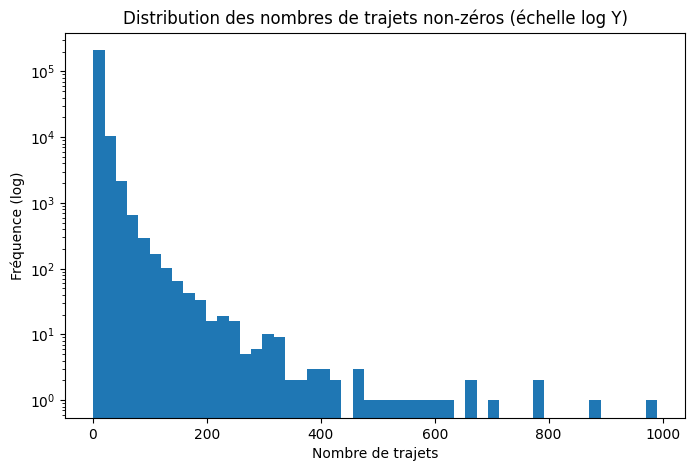

In [46]:
# Sparsité
sparsity = 1 - np.count_nonzero(A_np) / A_np.size
print(f"Sparsité de A : {sparsity:.2%}")  # % de zéros  

# Stats des counts non-zéros
non_zero = A_np[A_np > 0].flatten()
non_zero_series = pd.Series(non_zero)
print("Statistiques des counts non-zéros :\n", non_zero_series.describe())

mean = non_zero.mean()
var = non_zero.var()
print(f"Moyenne : {mean:.2f}, Variance : {var:.2f}")

# Histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(non_zero, bins=50, log=True)
plt.title('Distribution des nombres de trajets non-zéros (échelle log Y)')
plt.xlabel('Nombre de trajets')
plt.ylabel('Fréquence (log)')
plt.show()

La matrice $A$ a une sparsité de 63.08%, ce qui veut dire qu'elle contient 63.08% de zéros. D'un autre point de vue, sur 606,841 ($779 \times 779$) paires possibles, il y seulement 224,046 (36.92% de valeurs non-zéro) qui ont au moins 1 trajet. Cela suggère que le réseau de station est modéremment connecté. En ce qui concerne la distribution statistique des counts, le ratio écart-type / moyenne = 13.251891 / 6.554653 ≈ 2.02, ce qui indique une distribution asymétrique. 

On note aussi beaucoup de connexions faibles (25% des paires ont exactement 1 trajet, 50% ont ≤ 3 trajets) : il pourrait s'agir des trajets occasionnels ou des stations périphériques. On note également quelques connexions très fortes au-delà des 400 trajets, notamment une paire avec 990 (le maximum) trajets, ce qui fait environ 330 fois la médiane. Il s'agit problablement de stations centrales très proches géographiquement et situées dans une zone stratégiques, possiblement dans un park.



In [47]:
# Identification des paires i -> j avec plus de 600 trajets
# On utilise la table des comptages par origine/destination
pairs_300 = counts[counts['n_trips'] > 300].sort_values('n_trips', ascending=False)
print(f"Nombre de paires i→j > 300 trajets : {len(pairs_300)}")

# Ajout des noms + distance 
stations_lookup = stations.set_index('Station ID')[['Station Name', 'Latitude', 'Longitude']]

pairs_300 = pairs_300.join(
    stations_lookup, on='Start Station ID'
).rename(columns={
    'Station Name': 'Start Station Name',
    'Latitude': 'Start Latitude',
    'Longitude': 'Start Longitude'
})

pairs_300 = pairs_300.join(
    stations_lookup, on='End Station ID'
).rename(columns={
    'Station Name': 'End Station Name',
    'Latitude': 'End Latitude',
    'Longitude': 'End Longitude'
})

def compute_distance_km(row):
    if pd.notna(row['Start Latitude']) and pd.notna(row['End Latitude']):
        return haversine(
            row['Start Longitude'], row['Start Latitude'],
            row['End Longitude'], row['End Latitude']
        )
    return np.nan

pairs_300['distance_km'] = pairs_300.apply(compute_distance_km, axis=1)

pairs_300[[
    'Start Station ID', 'Start Station Name',
    'End Station ID', 'End Station Name',
    'n_trips', 'distance_km'
]].head(20)



Nombre de paires i→j > 300 trajets : 46


,Start Station ID,Start Station Name,End Station ID,End Station Name,n_trips,distance_km
63437,191,"Hyde Park Corner, Hyde Park",303,"Albert Gate, Hyde Park",990,0.342136
82588,248,"Triangle Car Park, Hyde Park",191,"Hyde Park Corner, Hyde Park",877,1.217746
63390,191,"Hyde Park Corner, Hyde Park",248,"Triangle Car Park, Hyde Park",789,1.217746
99928,303,"Albert Gate, Hyde Park",191,"Hyde Park Corner, Hyde Park",783,0.342136
101018,307,"Black Lion Gate, Kensington Gardens",404,"Palace Gate, Kensington Gardens",698,0.906521
100879,307,"Black Lion Gate, Kensington Gardens",191,"Hyde Park Corner, Hyde Park",671,2.492580
214903,786,"Lee Valley VeloPark, Queen Elizabeth Olympic Park",785,"Aquatic Centre, Queen Elizabeth Olympic Park",657,1.004048
130500,404,"Palace Gate, Kensington Gardens",307,"Black Lion Gate, Kensington Gardens",622,0.906521
215317,789,"Podium, Queen Elizabeth Olympic Park",785,"Aquatic Centre, Queen Elizabeth Olympic Park",597,0.264843
214812,785,"Aquatic Centre, Queen Elizabeth Olympic Park",789,"Podium, Queen Elizabeth Olympic Park",587,0.264843


Pour les paires de stations comptant plus de 300 trajets, on en dénombre 46 au total. L’examen de ces paires confirme pleinement les hypothèses formulées au préalable. Deux zones géographiques dominent très nettement cette catégorie :
- Hyde Park / Kensington Gardens,
- Queen Elizabeth Olympic Park.

Ces zones concentrent les flux les plus élevés, sur des distances très courtes (0.26–1.2 km), ce qui suggère des usages principalement récréatifs, touristiques ou internes à des espaces piétonniers.
Enfin, la présence de stations actives mais non référencées dans stations.csv (la station 300 par exemple) justifie leur maintien dans la matrice A, tout en les excluant des représentations géographiques faute de coordonnées disponibles.


##### Visualisation de la matrice A

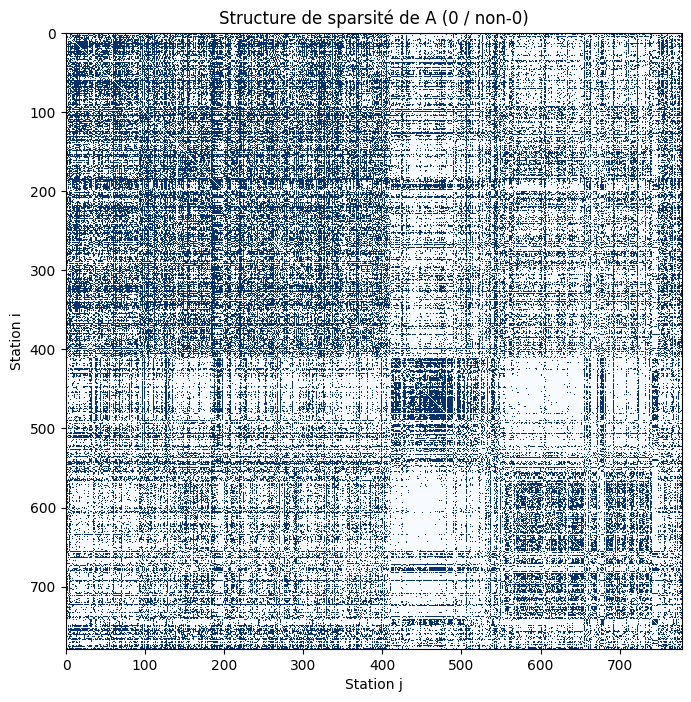

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
plt.imshow((A > 0), cmap="Blues", interpolation="nearest")
plt.title("Structure de sparsité de A (0 / non‑0)")
plt.xlabel("Station j")
plt.ylabel("Station i")
plt.show()

L'analyse visuelle de la matrice de sparsité révèle une hétérogénéité structurelle marquée, divisant le réseau en deux régimes distincts. La zone supérieure gauche (indices $i, j < 400$) présente une très forte densité, caractéristique d'un cœur de réseau central fortement maillé (probablement le centre-ville historique). À l'inverse, la zone des indices supérieurs ($i, j > 400$) montre une structure plus fragmentée avec des blocs denses locaux, suggérant des communautés périphériques (quartiers excentrés) qui interagissent fortement en interne mais moins avec les autres zones périphériques. 

Couplée avec le tableau précédent, l'analyse des trajets les plus fréquents valide la structure par blocs de la matrice d'adjacence. Les IDs faibles ($<400$) correspondent aux stations historiques du centre (ex: Hyde Park), formant le bloc dense supérieur gauche. Les IDs élevés ($>700$) correspondent aux extensions périphériques comme le Queen Elizabeth Olympic Park. La distance géographique importante entre ces pôles explique le nombre limité de connexions croisées (les zones blanches de la matrice) et confirme une utilisation du service en 'clusters' locaux plutôt que pour de longues traversées de la ville. 

In [49]:
# Symétrie de A
print(np.allclose(A_np, A_np.T))

asymmetry = np.linalg.norm(A_np - A_np.T) / np.linalg.norm(A_np)
print(f"Asymétrie relative : {asymmetry:.4f}")

False
Asymétrie relative : 0.4619


La matrice A n'est pas symétrique ! L'analyse visuelle de la sparsité laissait le pensait à cause de comment la sparsité est plotée. En effet, ce plot affiche un binaire A > 0; dès qu’il y a au moins un trajet dans un sens, la case est coloriée. Or, pour beaucoup de paires de stations, il existe des trajets dans les deux sens (i→j et j→i), ce qui fait apparaître des pixels à la fois en (i, j) et (j, i) et donne une impression de symétrie. Aussi, les intensités sont masquées (pas de différence entre 1 trajet et 400), donc même une faible réciprocité rend le motif *symétrique* et la diagonale est vide (self‑loops retirés), ce qui renforce le contraste et la *symétrie* autour de la diagonale.

### 3) Déduction de Z à partir de A 

Travailler directement sur la matrice d'adjacence brute $A$ ($779 \times 779$) est complexe en raison de sa grande taille et de la variabilité des données. En effet, le nombre de trajets $A_{ij}$ observé est soumis à de nombreux facteurs (météo, jour de la semaine, événements) qui peuvent masquer la véritable structure du réseau. De plus, la matrice est très creuse : le fait de ne pas observer de trajet entre deux stations (un zéro dans la matrice) ne signifie pas forcément que la connexion est impossible, mais peut simplement résulter d'un manque de données sur la période observée.

Pour dépasser ces limites, nous supposons l'existence d'une structure latente $Z$ plus simple. L'hypothèse est que les stations ne se comportent pas de manière isolée, mais qu'elles appartiennent à des groupes fonctionnels (hubs centraux, zones résidentielles, périphérie, etc.), ce que justement, nos analyses précédentes justifient clairement.

L'objectif de notre approche est donc d'estimer cette structure $Z$ de manière probabiliste. Pour ce faire, nous faisons l’hypothèse que chaque $A_{ij}$ est la réalisation d’une variable aléatoire dont la distribution dépend de paramètres latents. Autrement dit, au lieu de considérer $A$ comme une matrice fixe, nous supposons que :
$A_{ij} \sim p(A_{ij} \mid \Theta_{ij})$ où $\Theta_{ij}$ représente les paramètres de la distribution conditionnés par l'espace latent.

Cette approche va nous permettre de modéliser explicitement le bruit naturel présent dans les flux, d’obtenir une estimation de $Z$ plus robuste et de disposer d’une vraisemblance utile pour le clustering probabiliste (GMM) dans l’espace latent.

Notre méthode pour estimer $Z$ de manière probabiliste consiste à appliquer une Factorisation Matricielle Probabiliste sur la matrice $A$, adaptée aux données de comptage (une approche similaire à une ACP probabiliste (PPCA)). À ce propos, pour des données de comptage, les distributions les plus appropriées sont la Poisson et la Negative Binomial.

**Modèle Poisson** : $A_{ij}\mid Z \sim \mathrm{Poisson}(\lambda _{ij})$, avec $\lambda _{ij}>0$. La loi de Poisson impose : $\mathbb{E}[A_{ij}]=\mathrm{Var}(A_{ij})=\lambda _{ij}$

**Modèle Negative Binomial** : $A_{ij}\mid Z \sim \mathrm{NB}(\mu _{ij},\theta)$, avec $\mu _{ij}>0$. La Negative Binomial introduit un paramètre de dispersion $\theta$ , permettant de modéliser la surdispersion : $\mathrm{Var}(A_{ij})=\mu _{ij}+\frac{\mu _{ij}^2}{\theta }$

- Si $\theta$ est grand : la variance se rapproche de la moyenne (on revient à la loi Poisson).
- Si $\theta$ est petit : la variance devient beaucoup plus grande que la moyenne.

Le choix entre Poisson et Negative Binomial dépend donc directement des statistiques empiriques des flux $A_{ij}$. Dans la matrice $A$, la variance des nombre de trajets entre stations est largement supérieure à la moyenne. Nous sommes donc en situation de surdispersion, ce qui rend la Negative Binomial plus réaliste que la Poisson et bien plus adaptée qu’un modèle gaussien (qui est classique dans une ACP standard).

D'un autre côté, il faut souligner que dans notre jeu de données, il est légitime que certaines stations, en raison de leurs situations géographiques ou de tout autres motifs, ne puissent pas être connectées. Nous sommes donc dans un cas où, l'absence de trajets entre deux stations ($A_{ij}=0$) peut-être également structurellement vraie. Pour prendre en compte ce fait, au lieu de supposer une distribution negative binomiale simple, nous préfererons une Zero Inflated Negative Binomial pour gérer les zéro structurels et les zéro aléatoires. 

Par ailleurs, les flux étant dirigés, une station $i$ n'aura pas la même représentation latente en tant que station de départ et station d'arrivée. Dès lors, pour que le flux dépende de cette contrainte nous séparerons explicitement les représentations latentes pour introduire cette relation de bilinéarité. Le flux entre une station $i$ et une station $j$ sera alors modélisé à travers une interaction bilinéaire de la forme $\textit{affinité}(i,j)=Z_i^{\top }W_j$ avec $Z_i$ la représente latente de $i$ en tant que station de départ et $W_j$, la représentation latente de $j$ en tant que station d'arrivée. Pour faire l'analogie avec la PCA, $W_i$ représente en quelque sorte une composante de la matrice de projection.  


Finalement, notre modèle s'écrit

$$
A_{ij} \mid Z_i, W_j \sim \mathrm{ZINB}(\mu_{ij}, \theta, \pi_{ij})
$$

avec :

$$
p(A_{ij} = 0)
= \pi_{ij} + (1 - \pi_{ij}) \cdot \mathrm{NB}(0 \mid \mu_{ij}, \theta)
$$

$$
p(A_{ij} = k > 0)
= (1 - \pi_{ij}) \cdot \mathrm{NB}(k \mid \mu_{ij}, \theta)
$$

**Variables latentes et paramètres**

- $Z_i \in \mathbb{R}^q$ : embedding latent de la station $i$ (origine)
- $W_j \in \mathbb{R}^q$ : embedding latent de la station $j$ (destination)
- $\mu_{ij} = \exp(Z_i^\top W_j)$, pour forcer $\mu_{ij} > 0$
- $\theta > 0$ : paramètre de dispersion NB
- $\pi_{ij} \in (0,1)$ : probabilité de zéro‑inflation

Enfin, pour contrôler l’amplitude des variables latentes et éviter que $\mu_{ij}$ n’explose, nous imposerons des priors
gaussiens sur Z et W. De fait, pour le calcul du maximum de vraissemblance nous ajouterons une pénalisation
sur ces paramètres pour limiter la complexité du modèle comme en régression linéaire multiple.

### Formalisation mathématique de l'approche

Notre objectif est d'inférer les matrices latentes $Z$ (représentation latente des stations comme source) et $W$ (vecteur latent de destination) qui expliquent au mieux la matrice d'adjacence observée $A$.

Nous cherchons donc à maximiser la distribution de Z et W au vu des données $A_{i,j}$ de la matrice $A$ :

$$
\hat{Z}, \hat{W} = \underset{Z, W}{\mathrm{argmax}} \ p(Z, W \mid A)
$$

En appliquant la règle de Bayes et en passant au logarithme, cela équivaut à maximiser :

$$
\log p(Z, W \mid A) = \log p(A \mid Z, W) + \log p(Z) + \log p(W) + C
$$

Pour l'optimisation numérique, nous transformons ce problème de maximisation en un problème de minimisation de la Log-Vraisemblance Négative (NLL) pénalisée. La fonction de coût est :

$$
\mathcal{L}(Z, W) = - \log p(A \mid Z, W) - \log p(Z) - \log p(W)
$$

Nous imposons des priors gaussiens centrés et de mêmes variances dans toutes les directions sur les facteurs latents pour contrôler la complexité du modèle. Soient $Z_i \in \mathbb{R}^q$ et $W_j \in \mathbb{R}^q$ les vecteurs latents pour chaque station :

$$
Z_i \sim \mathcal{N}(0, \sigma^2 I), \quad W_j \sim \mathcal{N}(0, \sigma^2 I)
$$

Le logarithme de la densité du prior (en ignorant les constantes) correspond à une pénalisation $L_2$. En posant $\lambda = 1/\sigma^2$, le terme de régularisation devient :

$$
\mathcal{R}(Z, W) = -\log p(Z) - \log p(W) \propto \frac{\lambda}{2} \left( \sum_i \|Z_i\|^2 + \sum_j \|W_j\|^2 \right)
$$

**Définition de la vraisemblance (modèle ZINB)**

Nous supposons une indépendance conditionnelle des entrées de la matrice $A$ sachant les facteurs latents. La log-vraisemblance totale est la somme des contributions individuelles :

$$
\log p(A \mid Z, W) = \sum_{i,j} \ell_{ij}(A_{ij} \mid Z_i, W_j, \theta, \pi_{ij})
$$

Chaque entrée $A_{ij}$ suit une loi Zero-Inflated Negative Binomial (ZINB) paramétrée par :
- Moyenne du flux latent : $\mu_{ij} = \exp(Z_i^\top W_j)$
- Probabilité de zéro-inflation : $\pi_{ij} \in (0,1)$
- Dispersion : $\theta > 0$

La log-vraisemblance par point $\ell_{ij}$ se décompose en deux cas :

**Cas 1 : observation nulle ($A_{ij} = 0$)**

$$
\ell_{ij}^{(0)} = \log \left[ \pi_{ij} + (1 - \pi_{ij}) \left( \frac{\theta}{\theta + \mu_{ij}} \right)^\theta \right]
$$

**Cas 2 : observation positive ($A_{ij} = k > 0$)**

$$
\ell_{ij}^{(k)} = \log(1 - \pi_{ij}) + \log \Gamma(k + \theta) - \log \Gamma(\theta) - \log \Gamma(k+1) + \theta \log \theta + k \log \mu_{ij} - (k + \theta) \log(\theta + \mu_{ij})
$$

Le problème d'optimisation consiste à trouver $Z, W, \theta$ (et les paramètres de $\pi$) qui minimisent :

$$
\mathcal{L}_{\text{total}} = \underbrace{-\sum_{i,j} \ell_{ij}}_{\text{NLL (attache aux données)}} + \underbrace{\frac{\lambda}{2} \left( \sum_i \|Z_i\|^2 + \sum_j \|W_j\|^2 \right)}_{\text{Régularisation } L_2}
$$


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Fonction de perte 
def zinb_log_likelihood(x, mu, theta, pi_logits, eps=1e-8):
    # --- Partie Negative Binomial ---
    log_theta = torch.log(theta + eps)
    log_mu = torch.log(mu + eps)
    log_theta_mu = torch.log(theta + mu + eps)
    
    # Formule du log-NB 
    lgamma_diff = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1)
    log_nb = lgamma_diff + theta * (log_theta - log_theta_mu) + x * (log_mu - log_theta_mu)

    # --- Partie Zero-Inflation ---
    log_pi = -torch.nn.functional.softplus(-pi_logits)      # équivalent à log(sigmoid(logits))
    log_1_minus_pi = -torch.nn.functional.softplus(pi_logits) # équivalent à log(1 - sigmoid(logits))
    
    # Cas x = 0 : Log(P(0)) = Log( exp(log_pi) + exp(log_1_minus_pi + log_nb_zero) )
    log_prob_zero = torch.logaddexp(log_pi, log_1_minus_pi + log_nb)
    
    # Cas x > 0 : Log( (1-pi) * NB(x) )
    log_prob_nonzero = log_1_minus_pi + log_nb

    # Sélection conditionnelle
    return torch.where(x < 1e-8, log_prob_zero, log_prob_nonzero)


# Modèle
class ZINBFactorModel(nn.Module):
    def __init__(self, n_samples, n_features, n_components):
        super().__init__()
        # Initialisation petite pour éviter l'explosion de exp()
        self.Z = nn.Parameter(torch.randn(n_samples, n_components) * 0.01)
        self.W = nn.Parameter(torch.randn(n_features, n_components) * 0.01)

        self.log_theta = nn.Parameter(torch.tensor(0.0))
        self.logit_pi = nn.Parameter(torch.zeros(n_features))

    def forward(self):
        eta = self.Z @ self.W.T
        mu = torch.exp(eta)
        theta = torch.exp(self.log_theta)
        # On renvoie les LOGITS de pi, pas les probabilités
        return mu, theta, self.logit_pi 


# Setup
A = torch.tensor(A_np, dtype=torch.float32)

model = ZINBFactorModel(
    n_samples=A.shape[0],
    n_features=A.shape[1],
    n_components=17
)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Priors
sigma_z = 1.0
sigma_w = 1.0
prior_z = torch.distributions.Normal(0.0, sigma_z)
prior_w = torch.distributions.Normal(0.0, sigma_w)


# Training
print("Démarrage de l'entraînement...")

for epoch in range(2001):
    optimizer.zero_grad()

    mu, theta, logit_pi = model()

    ll = zinb_log_likelihood(A, mu, theta, logit_pi).sum()

    # Log-priors
    log_pz = prior_z.log_prob(model.Z).sum()
    log_pw = prior_w.log_prob(model.W).sum()

    # Maximiser LL => Minimiser -LL
    loss = -(ll + log_pz + log_pw)

    # Diagnostic NaN 
    if torch.isnan(loss):
        print("Arrêt: NaN détecté !")
        break

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2f}")


# Diagnostics & Sauvegarde
with torch.no_grad():
    mu_est, _, logit_pi_est = model()
    
    # Paramètres globaux
    theta_est = torch.exp(model.log_theta).item()
    # On applique sigmoid ici pour l'affichage (probabilité)
    pi_probs = torch.sigmoid(logit_pi_est)
    pi_mean = pi_probs.mean().item()

    # Reconstruction de l'espérance mathématique E[A] = (1-pi) * mu
    A_reconstructed = (1 - pi_probs) * mu_est
    A_reconstructed = A_reconstructed.detach().cpu().numpy()

# Normalisation Standard (Centrer-Réduire) pour le clustering
Z_zinb = model.Z.detach().cpu().numpy()
Z_mean = Z_zinb.mean(axis=0)
Z_std = Z_zinb.std(axis=0)
Z_zinb_norm = (Z_zinb - Z_mean) / (Z_std + 1e-8)

np.save("Z_zinb.npy", Z_zinb_norm)

mse = np.mean((A_np - A_reconstructed) ** 2)

print("-" * 30)
print(f"MSE Reconstruction: {mse:.4f}")
print(f"Dispersion (Theta): {theta_est:.4f}")
print(f"Zero-Inflation Moyenne (Pi): {pi_mean * 100:.2f}%")
print(f"Dimensions de Z: {Z_zinb_norm.shape}")
print("-" * 30)

Démarrage de l'entraînement...
Epoch 0, Loss: 1463113.25
Epoch 200, Loss: 784046.69
Epoch 400, Loss: 750328.19
Epoch 600, Loss: 745623.50
Epoch 800, Loss: 744298.62
Epoch 1000, Loss: 743711.19
Epoch 1200, Loss: 743393.12
Epoch 1400, Loss: 743192.25
Epoch 1600, Loss: 743057.00
Epoch 1800, Loss: 742963.19
Epoch 2000, Loss: 742893.25
------------------------------
MSE Reconstruction: 36.8086
Dispersion (Theta): 1.7293
Zero-Inflation Moyenne (Pi): 4.17%
Dimensions de Z: (779, 17)
------------------------------


Commentaire : Les résultats de l'entraînement confirment la pertinence de l'approche ZINB. La convergence rapide de la fonction de perte témoigne de la stabilité de l'inférence MAP. L'estimation du paramètre de dispersion $\theta ≈ 1.73$ révèle une forte surdispersion, invalidant l'hypothèse de Poisson classique au profit de la Negative Binomial. Enfin, la composante de zéro-inflation ($\pi ≈ 4.2%$) joue un rôle de régulation fin, capturant les absences structurelles de connexion sans sur-contraindre le modèle, laissant la loi de comptage gérer la sparsité naturelle des flux.

### 4) Modélisation probabiliste sur Z

#### Choix du K optimal : méthode du coude sur BIC

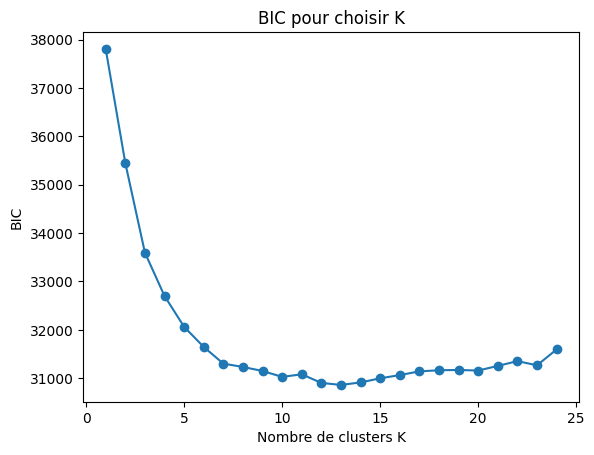

In [26]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

bics = []
ks = range(1, 25)
for k in ks:
    gmm = GaussianMixture(n_components=k, n_init=10, covariance_type = "diag", random_state=42)
    gmm.fit(Z_zinb_norm)
    bics.append(gmm.bic(Z_zinb_norm))

plt.plot(ks, bics, marker='o')
plt.title('BIC pour choisir K')
plt.xlabel('Nombre de clusters K')
plt.ylabel('BIC')
plt.show()  


Commentaire : L'analyse du critère d'information bayésien (BIC) en fonction du nombre de composants révèle un profil convexe caractéristique. Une diminution rapide du BIC est observée jusqu'à K=7, suivie d'une stabilisation. Le minimum global est atteint pour K=13, valeur que nous retenons comme compromis optimal entre la complexité du modèle et sa capacité à capturer la structure latente des flux.

#### Modélisation de Z par une Gaussian Mixture avec K = 13 

In [51]:
import pandas as pd
from sklearn.mixture import GaussianMixture


optimal_k = 13  

print(f"Entraînement du GMM final avec K={optimal_k}...")

gmm_final = GaussianMixture(
    n_components=optimal_k, 
    n_init=50,              # 50 redémarrages pour éviter les minimums locaux
    covariance_type="diag", # Cohérence avec l'indépendance des variables latentes ZINB
    random_state=42
)

# Fit et prédiction directe (Inférence)
labels = gmm_final.fit_predict(Z_zinb_norm)


# Métriques et Statistiques du modèle

# Récupération des probabilités d'appartenance (soft assignment)
probas = gmm_final.predict_proba(Z_zinb_norm)

# Calcul de la Log-Vraisemblance totale
# .score() renvoie la moyenne par échantillon, on multiplie par N pour le total
log_lik_total = gmm_final.score(Z_zinb_norm) * Z_zinb_norm.shape[0]

print("-" * 30)
print(f"Log-vraisemblance totale : {log_lik_total:.2f}")
print(f"Shape des moyennes (Centres des clusters) : {gmm_final.means_.shape}")
print("-" * 30)


# Création du DataFrame de Résultats
df_clusters = pd.DataFrame({
    'Station_Index': range(len(labels)),
    'Cluster_Label': labels,
    'Confidence': probas.max(axis=1) # Certitude du modèle pour cette station
})

Entraînement du GMM final avec K=13...
------------------------------
Log-vraisemblance totale : -13892.00
Shape des moyennes (Centres des clusters) : (13, 17)
------------------------------


Commentaire : La log-vraisemblance totale du modèle final s'établit à -13 892, une valeur supérieure à celle obtenue pour des K plus élevés (ex: -13 950 pour K=14). Ce gain d'ajustement, malgré la réduction du nombre de paramètres, confirme que la structure à 13 communautés capture le plus fidèlement la structure latente des flux, sans bruit inutile ni sur-segmentation.

In [52]:

# Affichage des résultats
print("\nRépartition des stations par cluster :")
print(df_clusters['Cluster_Label'].value_counts().sort_index())

print("\nExemple des 5 premières stations avec leur cluster et confiance :")
print(df_clusters.head())


Répartition des stations par cluster :
Cluster_Label
0      67
1      79
2      78
3      31
4      50
5      63
6     101
7      78
8      34
9      63
10     62
11     42
12     31
Name: count, dtype: int64

Exemple des 5 premières stations avec leur cluster et confiance :
   Station_Index  Cluster_Label  Confidence
0              0              0    0.999830
1              1              1    0.965620
2              2              4    0.999999
3              3              0    0.999998
4              4              2    0.999860


L'analyse des résultats du clustering révèle une structure équilibrée composée de 13 communautés de tailles comparables (31 à 101 stations), sans prédominance d'un groupe unique. Les probabilités d'appartenance extrêmement élevées (>99% pour la majorité des stations testées) confirment que la projection dans l'espace latent ZINB a généré des groupes fonctionnels distincts et bien séparés, validant la capacité du modèle à filtrer la variabilité aléatoire des flux.

In [53]:
print("\n\nExemple de probs pour première station :", probas[0])

# Exemple d'analyse : Paramètres du cluster 0 (Poids π)
weights_str = ", ".join([f"{w:.4f}" for w in gmm_final.weights_])
print(f"\nPoids des clusters (Proportion du dataset) : [{weights_str}]")



Exemple de probs pour première station : [9.9983019e-01 5.2887337e-26 3.1079039e-24 3.4229303e-12 5.0777307e-06
 8.0529972e-15 7.9992288e-16 1.6503493e-04 9.9132334e-12 1.2746397e-09
 4.9431566e-21 4.4410406e-11 5.1787516e-18]

Poids des clusters (Proportion du dataset) : [0.0854, 0.1011, 0.0980, 0.0401, 0.0647, 0.0815, 0.1302, 0.0985, 0.0448, 0.0809, 0.0798, 0.0536, 0.0414]


L'examen des probabilités d'appartenance montre une sélectivité extrême du modèle. Pour la station témoin 0, la probabilité d'appartenance au cluster dominant dépasse 99.9%, reléguant les autres clusters à des valeurs négligeables. Cette faible entropie dans l'assignation confirme que les représentations latentes $Z$ sont géométriquement bien séparées, validant la capacité du modèle ZINB à créer des profils de stations distincts.

La distribution des poids du mélange gaussien révèle une segmentation équilibrée du réseau. Avec des proportions variant entre 4% et 13%, le modèle évite l'écueil classique de la création d'un 'cluster fourre-tout' ou de l'émiettement excessif. Cela suggère que la structure des flux londoniens s'organise naturellement autour de 13 communautés de tailles comparables, chacune jouant un rôle structurel significatif.

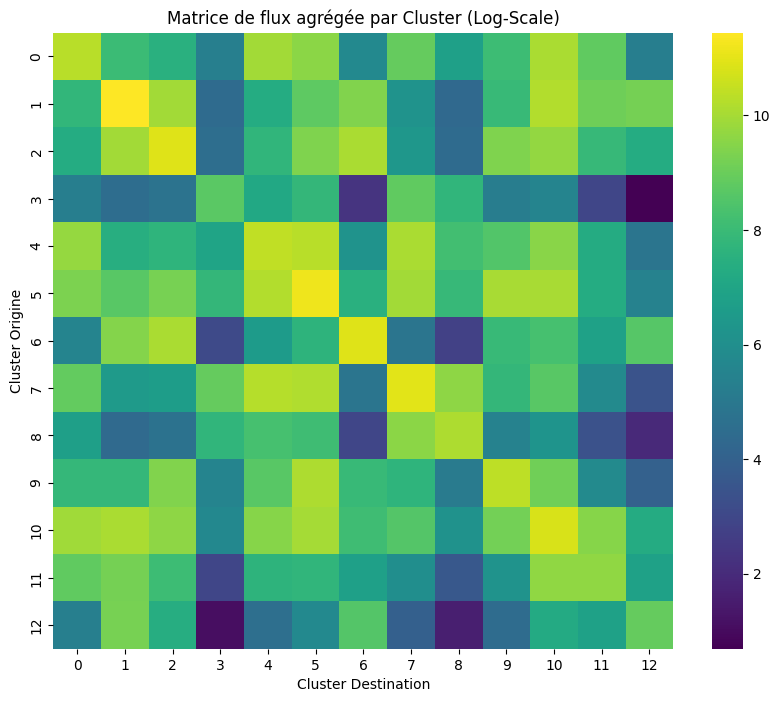

In [54]:
import seaborn as sns
# Création de la matrice d'adjacence réduite (14x14)
K = optimal_k
matrix_cluster = np.zeros((K, K))

clusters = df_clusters['Cluster_Label'].values

# On somme les flux de la matrice originale A
for i in range(A_np.shape[0]):
    for j in range(A_np.shape[1]):
        cluster_i = labels[i]
        cluster_j = labels[j]
        matrix_cluster[cluster_i, cluster_j] += A_np[i, j]

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(
    np.log1p(matrix_cluster), # Log pour mieux voir les contrastes
    annot=False, 
    cmap="viridis",
    xticklabels=range(K),
    yticklabels=range(K)
)
plt.title("Matrice de flux agrégée par Cluster (Log-Scale)")
plt.xlabel("Cluster Destination")
plt.ylabel("Cluster Origine")
plt.show()

Commentaire : La matrice des flux agrégée révèle une structure à deux niveaux. Premièrement, une forte dominance intra-cluster (la diagonale) confirme que les communautés détectées correspondent à des bassins de mobilité locale cohérents. Deuxièmement, on distingue clairement une hiérarchie : des clusters centraux (ex: 4, 10) agissant comme des hubs communs connectés à tout le réseau, s'opposant à des clusters périphériques (ex: 3, 8) dont les interactions sont sélectives et limitées géographiquement. Cette structure valide la capacité du modèle ZINB à discriminer les zones non seulement par leur profil interne, mais aussi par leur rôle dans le système global.

##### Visualisation en 2D avec TSNE

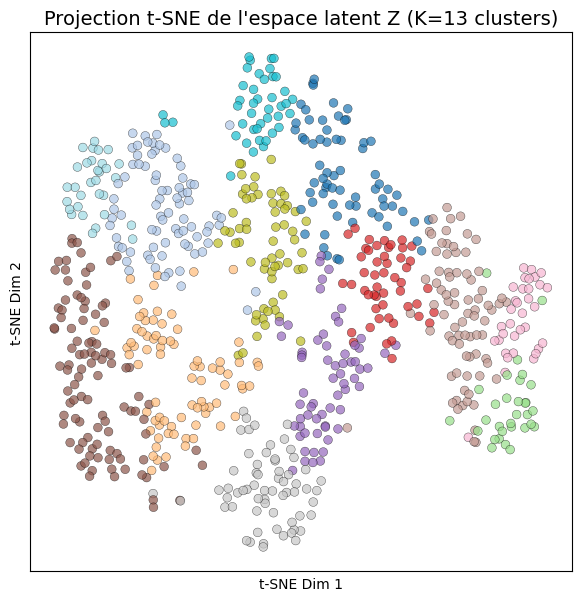

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Calcul du t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
Z_2d = tsne.fit_transform(Z_zinb_norm)

# Visualisation
plt.figure(figsize=(7, 7))

# Utilisation de 'tab20' qui offre 20 couleurs distinctes (parfait pour K=14)
scatter = plt.scatter(
    Z_2d[:, 0], 
    Z_2d[:, 1], 
    c=clusters, 
    cmap='tab20', 
    s=40,           # Taille des points
    alpha=0.7,      # Transparence pour voir les superpositions
    edgecolor='k',  # Petit contour noir pour mieux détacher les points
    linewidth=0.3
)

plt.title(f'Projection t-SNE de l\'espace latent Z (K={K} clusters)', fontsize=14)
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')

# Retrait les ticks qui n'ont pas de sens physique en t-SNE
plt.xticks([])
plt.yticks([])

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Commentaire : La projection t-SNE de l'espace latent révèle une topologie riche et structurée. Loin d'être aléatoire, la distribution des stations s'organise en un archipel de communautés. La présence d'un partie centrale (probablement le tissu urbain dense) contraste avec des îlots périphériques nettement détachés (zones spécialisées). Cette cohérence géométrique, en adéquation parfaite avec les étiquettes du clustering GMM, valide définitivement la capacité du modèle ZINB à extraire des signaux de mobilité intelligibles.

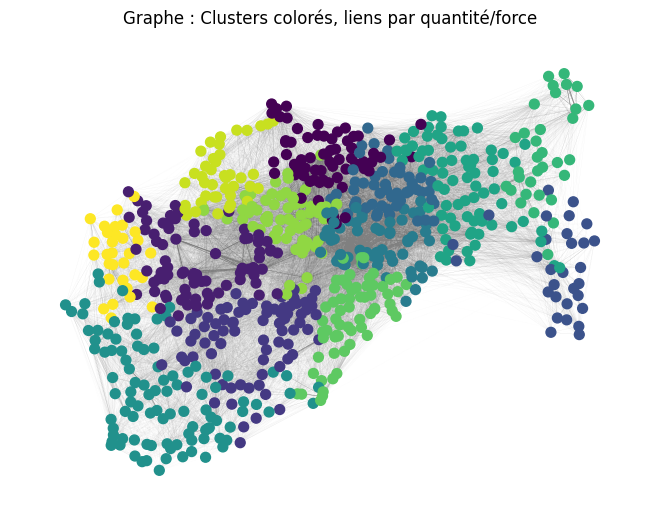

In [56]:
import networkx as nx
import pandas as pd

# Positions geo (NaN pour les 8 extra)
pos = {}
for i, sid in enumerate(all_station_ids):
    station_data = stations[stations['Station ID'] == sid]
    if not station_data.empty:
        pos[sid] = (station_data['Longitude'].values[0], station_data['Latitude'].values[0])

G = nx.Graph()
for i, sid in enumerate(all_station_ids):
    if sid in pos:
        G.add_node(sid, pos=pos[sid], cluster=clusters[i])

threshold = 5 
for i in range(n_stations):
    for j in range(i+1, n_stations):
        weight = A_np[i,j]
        # On ajoute l'arête seulement si les deux nœuds ont une position
        if weight > threshold and all_station_ids[i] in pos and all_station_ids[j] in pos:
            G.add_edge(all_station_ids[i], all_station_ids[j], weight=weight)

# Filtre pos pour ne garder que les nœuds du graphe
pos_filtered = {n: pos[n] for n in G.nodes() if n in pos}

# Dessin (geo ou spring si NaN)
# Calcul du max_weight si le graphe a des arêtes
if len(G.edges()) > 0:
    max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
    edge_widths = [d['weight']/max_weight for u, v, d in G.edges(data=True)]
else:
    edge_widths = 0.1

nx.draw(G, pos_filtered, node_color=[G.nodes[n]['cluster'] for n in G.nodes if 'cluster' in G.nodes[n]], cmap='viridis', node_size=50, edge_color='gray', width=edge_widths)
plt.title('Graphe : Clusters colorés, liens par quantité/force')
plt.show()

Commentaire : La projection spatiale du graphe valide la cohérence géographique des communautés identifiées. Le regroupement physique des clusters confirme que le modèle a su capturer la proximité spatiale uniquement à travers l'intensité des flux. Par ailleurs, la visualisation des connexions révèle une organisation de type « centre-périphérie », caractérisée par un noyau central dense et des zones périphériques plus autonomes.

##### Visualisation du clustering sur la carte géographique

Stations total: 773
Avec coords: 773
Avec cluster: 771
Affichées (coords + cluster): 771
Carte sauvegardée comme 'stations_clusters_map.html'


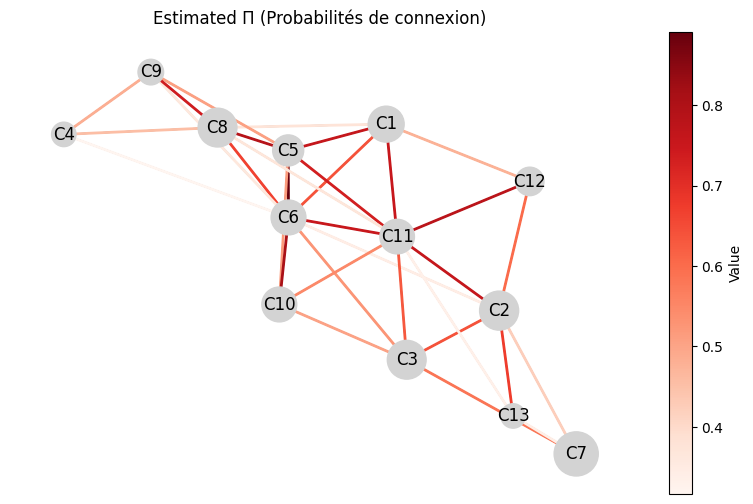

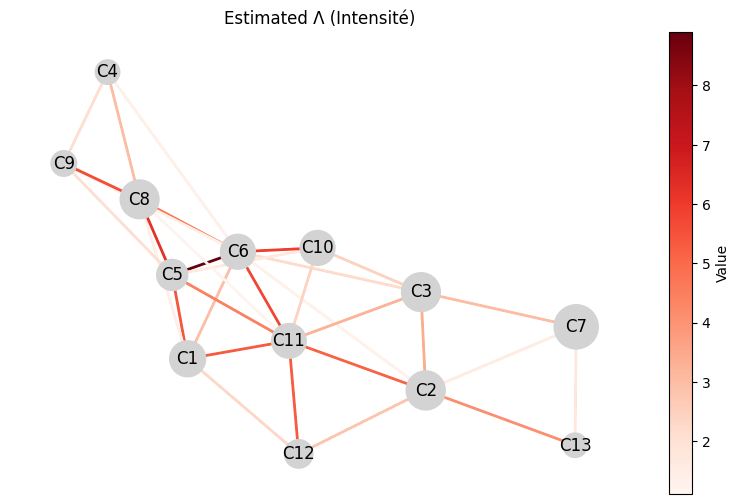

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import folium 
from folium.plugins import MarkerCluster


# On réutilise le all_station_ids construit plus haut
# Utiliser le modèle GMM choisi (K attendu)
gmm_used = gmm_final if 'gmm_final' in globals() else gmm
k_target = optimal_k if 'optimal_k' in globals() else gmm_used.n_components

if gmm_used.n_components != k_target:
    from sklearn.mixture import GaussianMixture
    gmm_used = GaussianMixture(n_components=k_target, random_state=42)
    gmm_used.fit(Z_zinb_norm)

clusters = gmm_used.predict(Z_zinb_norm)  # Cluster le plus probable (hard assignment)
probs = gmm_used.predict_proba(Z_zinb_norm)  # Probabilités soft pour chaque cluster

# K cohérent avec le modèle utilisé
k = gmm_used.n_components

# Couleurs distinctes façon HSV (espacement doré pour éviter les doublons)
import matplotlib.colors as mcolors

golden_ratio = 0.61803398875
hues = [(0.05 + i * golden_ratio) % 1.0 for i in range(k)]  # évite 0/1 pour ne pas coller
colors = [mcolors.hsv_to_rgb((h, 0.9, 0.95)) for h in hues]
# Convertir en hex pour folium et graphes
color_hex_list = [mcolors.to_hex(c) for c in colors]
# Alias pour compatibilité avec le reste de la cellule
colors_hex = color_hex_list

# Icône SVG (camembert) pour Folium
def create_svg_icon(probs_list, colors, size=24):
    slices = [(i, p) for i, p in enumerate(probs_list) if p > 0]
    if not slices:
        return f'<svg width="{size}" height="{size}"><circle cx="{size/2}" cy="{size/2}" r="{size/2}" fill="gray"/></svg>'

    total_p = sum([s[1] for s in slices])
    cx, cy, r = size / 2, size / 2, size / 2
    start_angle = 0.0
    paths = []

    import math

    for i, p in slices:
        rel_p = p / total_p
        end_angle = start_angle + rel_p * 2 * math.pi

        x1 = cx + r * math.cos(start_angle)
        y1 = cy + r * math.sin(start_angle)
        x2 = cx + r * math.cos(end_angle)
        y2 = cy + r * math.sin(end_angle)

        large_arc = 1 if rel_p > 0.5 else 0
        color = colors[i % len(colors)]
        path = (
            f'<path d="M {cx} {cy} L {x1} {y1} '
            f'A {r} {r} 0 {large_arc} 1 {x2} {y2} Z" '
            f'fill="{color}" stroke="white" stroke-width="0.5"/>'
        )
        paths.append(path)
        start_angle = end_angle

    return f'<svg width="{size}" height="{size}" viewBox="0 0 {size} {size}">{"".join(paths)}</svg>'

# Ici, on associe les clusters et les probabilités aux stations
# On aligne explicitement la taille avec les sorties du modèle
n_model = len(clusters)
station_cluster = pd.DataFrame({
    'Station ID': all_station_ids[:n_model],
    'cluster': clusters
})
# Ajout des probabilités pour chaque cluster
for i in range(k):
    station_cluster[f'prob_cluster_{i}'] = probs[:, i]

stations_with_clusters = stations.merge(station_cluster, on='Station ID', how='left')

# Plot 1: Carte géographique des stations avec clusters colorés selon probabilités (soft clustering)
# folium pour map interactive de Londres avec pie charts
import base64
from io import BytesIO
import os

map_center = [51.5074, -0.1278]  # Centre Londres
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap')

# Création d'un dossier temporaire pour les pie charts
pie_dir = 'pie_charts_temp'
os.makedirs(pie_dir, exist_ok=True)

prob_cols = [f'prob_cluster_{i}' for i in range(k)]
for col in prob_cols:
    if col not in stations_with_clusters.columns:
        stations_with_clusters[col] = 0.0

# Diagnostics visibilité
n_total = len(stations_with_clusters)
mask_coords = stations_with_clusters['Latitude'].notna() & stations_with_clusters['Longitude'].notna()
mask_cluster = stations_with_clusters['cluster'].notna()
print(f"Stations total: {n_total}")
print(f"Avec coords: {mask_coords.sum()}")
print(f"Avec cluster: {mask_cluster.sum()}")
print(f"Affichées (coords + cluster): {(mask_coords & mask_cluster).sum()}")
missing_ids = stations_with_clusters.loc[~mask_coords, 'Station ID'].dropna().astype(int).tolist()
if missing_ids:
    print(f"Stations sans coords (non affichées): {missing_ids}")

for idx, row in stations_with_clusters.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']) and pd.notna(row['cluster']):
        # Récupération des probabilités pour tous les clusters
        probs_list = [float(row[c]) for c in prob_cols]
        
        # Tri des probabilités et Top N clusters (au lieu d'un seuil fixe) pour afficher plus de couleurs
        all_probs = [(i, p) for i, p in enumerate(probs_list) if p > 0]  # On filtre les prob = 0
        all_probs.sort(key=lambda x: x[1], reverse=True)
        # On garde les top 3-5 clusters pour garantir plusieurs couleurs dans les pie charts
        if len(all_probs) >= 3:
            # priorité aux plus probables
            n_top = min(5, len(all_probs))
            significant_probs = all_probs[:n_top]
        else:
            # Si moins de 3 clusters, on prend tous ceux disponibles
            significant_probs = all_probs
        
        if len(significant_probs) > 0:
            # Création d'un pie chart avec fond transparent
            fig = plt.figure(figsize=(1, 1), facecolor='none', dpi=150)
            ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.axis('off')
            ax.set_aspect('equal')
            
            # Données pour le pie chart
            sizes = [p for _, p in significant_probs]
            labels_idx = [i for i, _ in significant_probs]
            pie_colors = [color_hex_list[i % len(color_hex_list)] for i in labels_idx]
            
            #  On crée des pie chart avec un contour fin pour séparer les segments
            wedges, texts = ax.pie(sizes, colors=pie_colors, startangle=90, 
                                   counterclock=False, normalize=True,
                                   wedgeprops=dict(width=1, edgecolor='white', linewidth=0.3))
            
            # Sauvegarde en mémoire
            buf = BytesIO()
            fig.patch.set_facecolor('none')
            fig.patch.set_alpha(0)
            plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, 
                       facecolor='none', transparent=True, dpi=150, edgecolor='none')
            buf.seek(0)
            img_data = base64.b64encode(buf.read()).decode('utf-8')
            plt.close(fig)
            
            # Icône personnalisée avec fond transparent
            icon_html = f'<img src="data:image/png;base64,{img_data}" width="16" height="16" style="display: block;">'
            icon = folium.DivIcon(html=icon_html, icon_size=(16, 16), icon_anchor=(8, 8), class_name='pie-chart-icon')
            
            # Popup avec informations sur les probabilités
            top_clusters = sorted(list(enumerate(probs_list)),
                                  key=lambda x: x[1], reverse=True)[:3]
            st_name = row['Station Name'] if pd.notna(row.get('Station Name')) else f"Station {row['Station ID']}"
            popup_text = (
                f"<b>Station:</b> {st_name}<br>"
                f"<b>ID:</b> {row['Station ID']}<br>"
                f"<hr>"
                f"<b>Cluster Majoritaire:</b> {int(row['cluster'])}<br>"
                f"<b>Détail:</b><br>"
                + "".join([f"Cluster {i}: {p*100:.1f}%<br>" for i, p in top_clusters])
            )
            
            # Marqueur avec l'icône pie chart
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                icon=icon,
                popup=folium.Popup(popup_text, max_width=200)
            ).add_to(m)

# Sauvegarde
m.save('stations_clusters_map.html')
print("Carte sauvegardée comme 'stations_clusters_map.html'")

# Plot 2: Graphes pour Π (probas connexions) et Λ (intensités) entre clusters 
# On agrége A par clusters : Π = proba lien (fraction liens >0), Λ = moyenne intensité (trajets)
cluster_pairs = np.zeros((k, k))
intensity_pairs = np.zeros((k, k))
count_pairs = np.zeros((k, k))

n_model = len(clusters)
for i in range(n_model):
    for j in range(i+1, n_model):
        c_i = clusters[i]
        c_j = clusters[j]
        weight = A_np[i, j]
        cluster_pairs[c_i, c_j] += (weight > 0)  # Pour proba
        intensity_pairs[c_i, c_j] += weight
        count_pairs[c_i, c_j] += 1
        # Symétrisation
        cluster_pairs[c_j, c_i] = cluster_pairs[c_i, c_j]
        intensity_pairs[c_j, c_i] = intensity_pairs[c_i, c_j]
        count_pairs[c_j, c_i] = count_pairs[c_i, c_j]

# Normalisation
pi_matrix = cluster_pairs / np.maximum(count_pairs, 1)  # Proba lien
lambda_matrix = intensity_pairs / np.maximum(count_pairs, 1)  # Moyenne intensité

# Taille nœuds : Taille clusters
cluster_sizes = np.bincount(clusters, minlength=k)

# Fonction pour dessiner graphe (commun pour Π et Λ)
def draw_cluster_graph(matrix, title, cmap, threshold=0.3, scale_factor=100):
    G = nx.Graph()
    for c in range(k):
        G.add_node(c, size=cluster_sizes[c] * scale_factor, label=f"C{c+1}")

    for c_i in range(k):
        for c_j in range(c_i+1, k):
            value = matrix[c_i, c_j]
            if value > threshold:
                G.add_edge(c_i, c_j, weight=value)

    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[n]['size'] for n in G.nodes]
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
    edge_weights = [d['weight'] for u,v,d in G.edges(data=True)]
    edge_colors = edge_weights  # Pour colormap

    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(G, pos, ax=ax, node_size=node_sizes, node_color='lightgray', with_labels=False)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=node_labels)
    if len(edge_weights) > 0:
        nx.draw_networkx_edges(G, pos, ax=ax, width=2, edge_color=edge_colors, edge_cmap=cmap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])  # Nécessaire pour ScalarMappable
        plt.colorbar(sm, ax=ax, label='Value')
    else:
        # Pas d'arêtes, pas de colorbar
        pass
    ax.set_title(title)
    plt.show()

# Π (probas, threshold 0.3)
draw_cluster_graph(pi_matrix, 'Estimated Π (Probabilités de connexion)', plt.cm.Reds, threshold=0.3, scale_factor=10)

# Λ (intensités, threshold 1)
draw_cluster_graph(lambda_matrix, 'Estimated Λ (Intensité)', plt.cm.Reds, threshold=1, scale_factor=10)

Commentaire : L'analyse de la matrice ($\Pi$) sous forme de graphe met en évidence l'architecture relationnelle du réseau. Une structure centralisée émerge autour du Cluster 11, qui agit comme un le coeur du réseau maintenant de fortes probabilités d'interaction avec la majorité des autres communautés (notamment C1, C2, C5 et C6).

À l'inverse, les clusters périphériques (tels que C4, C9 ou C7) présentent une connectivité plus exclusive : ils dépendent de liens forts avec le cœur du réseau pour s'y intégrer, illustrant une dépendance structurelle vis-à-vis des hubs centraux

L'analyse du graphe des intensités ($\Lambda$) permet de visualiser le volume réel des déplacements. On repère immédiatement une liaison très intense entre les clusters C5 et C6 (trait rouge foncé) : c'est l'axe principal de circulation de la ville. Cela contraste avec les zones périphériques (comme C4, C7 ou C13) dont les liens sont beaucoup plus faibles.

En conclusion, même si la périphérie est bien connectée au réseau (comme vu précédemment avec la matrice $\Pi$), elle ne représente qu'une très petite partie du trafic total, qui reste massivement concentré au centre.

### Interprétation de la carte et conclusion 

La cartographie présente une reconstruction fidèle des quartiers de Londres, ce qui confirme que les communautés latentes détectées par le modèle ZINB ne sont pas des artefacts statistiques, mais bien des territoires fonctionnels. Le modèle a réussi à identifier la structure socio-économique de Londres (quartiers résidentiels, zones d'affaires, pôles isolés) uniquement en analysant les traces laissées par les déplacements des vélos.

L'aspect le plus intéressant est la continuité spatiale. Le modèle n'a pas créé un "confetti" de points aléatoires, mais a redessiné les véritables quartiers de Londres sans connaître leurs coordonnées GPS. Le Bloc Sud-Ouest (Violet - Cluster 6) couvre une immense zone résidentielle (Chelsea, Fulham, Wandsworth). Sa taille explique pourquoi c'est le cluster le plus peuplé. Le Cœur Économique (Jaune - Cluster 5) correspond précisément à la "City" et ses alentours, le poumon financier de la ville. L'Est "Insulaire" (Rose - Cluster 3), tout à fait à droite et isolé correspond au Parc Olympique de Stratford. Sa position excentrée explique pourquoi il apparaissait détaché sur le t-SNE et les graphes de connexion.

Le graphe des intensités de connexion montrait un lien rouge intense entre C6 et C5. La carte nous donne la clé de lecture sociologique. En réalité, c'est l'axe pendulaire classique Domicile-Travail. Les flux massifs partent des zones résidentielles aisées du Sud-Ouest (Violet / C6) pour rejoindre le centre d'affaires (Jaune / C5) le matin, et inversement le soir.

La carte révèle également comment le fleuve structure la mobilité. Le Cluster 1 (Bleu Foncé) longe la rive sud (South Bank/Waterloo), agissant comme une zone tampon. On voit que certains clusters (comme le Orange C0 ou le Rouge C8 au Nord) ne traversent jamais la rivière, restant confinés à leur rive. Cela confirme que la Tamise reste une frontière physique et psychologique forte pour les cyclistes.

## Discussion : utilisation des données du professeur et comparaison.

In [58]:
# Données du professeur
A_prof = np.load('A_npy.npy')
Z_prof = np.load('Z.npy')
mu_z = np.load('mu_z.npy')

# Normalisation de Z
Z_prof_norm = (Z_prof - Z_prof.mean(axis=0)) / (Z_prof.std(axis=0) + 1e-8)

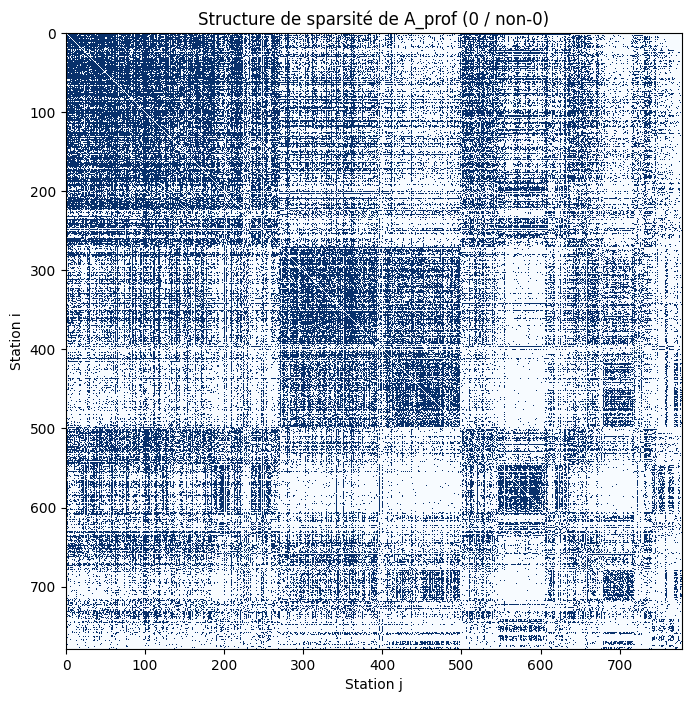

In [59]:
# Visualisation de la sparsité de A

plt.figure(figsize=(8, 8))
plt.imshow((A_prof > 0), cmap="Blues", interpolation="nearest")
plt.title("Structure de sparsité de A_prof (0 / non‑0)")
plt.xlabel("Station j")
plt.ylabel("Station i")
plt.show()

In [60]:
# On fait le choix de K = 13 comme dans nos analyses

optimal_k_prof = 13


# GMM et inférence
gmm_final_prof = GaussianMixture(
    n_components=optimal_k_prof,
    n_init=50,
    covariance_type="diag",
    random_state=42
)
gmm_final_prof.fit(Z_prof_norm)

clusters_prof = gmm_final_prof.predict(Z_prof_norm)
probs_prof = gmm_final_prof.predict_proba(Z_prof_norm)

log_lik_total_prof = gmm_final_prof.score(Z_prof_norm) * Z_prof_norm.shape[0]
print(f"K (même que le nôtre) : {optimal_k_prof}")
print(f"Log-vraisemblance totale : {log_lik_total_prof:.2f}")
print("Poids des clusters:", np.round(gmm_final_prof.weights_, 4))


K (même que le nôtre) : 13
Log-vraisemblance totale : 16188.76
Poids des clusters: [0.1073 0.125  0.067  0.1292 0.0013 0.0946 0.1883 0.0805 0.0885 0.0747
 0.0102 0.0013 0.0321]


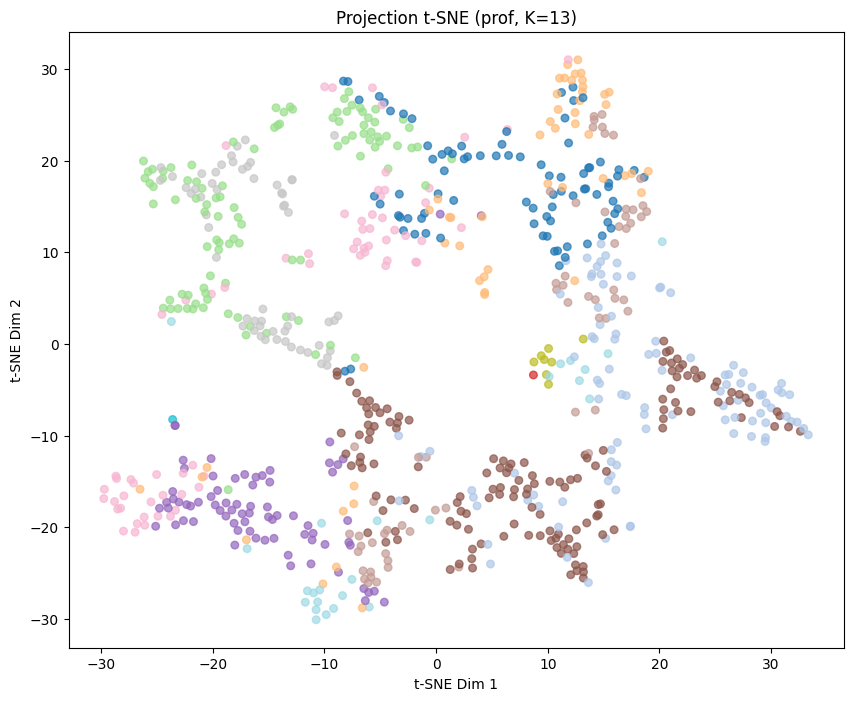

In [61]:

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
Z_2d = tsne.fit_transform(Z_prof_norm)

plt.figure(figsize=(10, 8))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=clusters_prof, cmap='tab20', s=30, alpha=0.7)
plt.title(f'Projection t-SNE (prof, K={optimal_k_prof})')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()


Commentaire

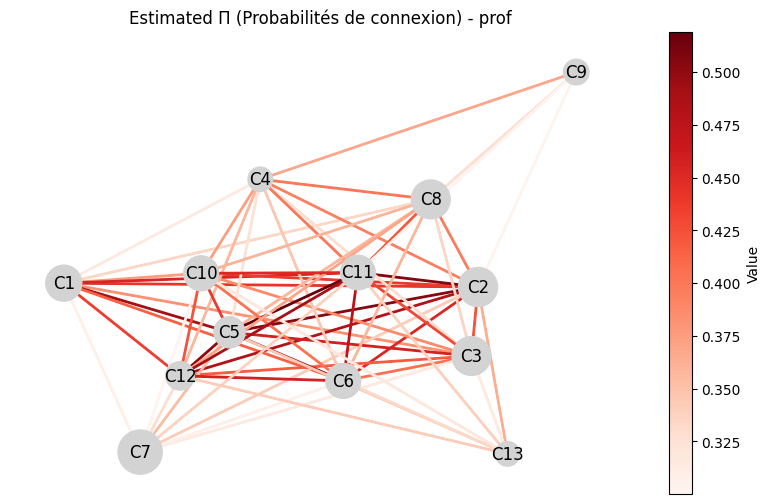

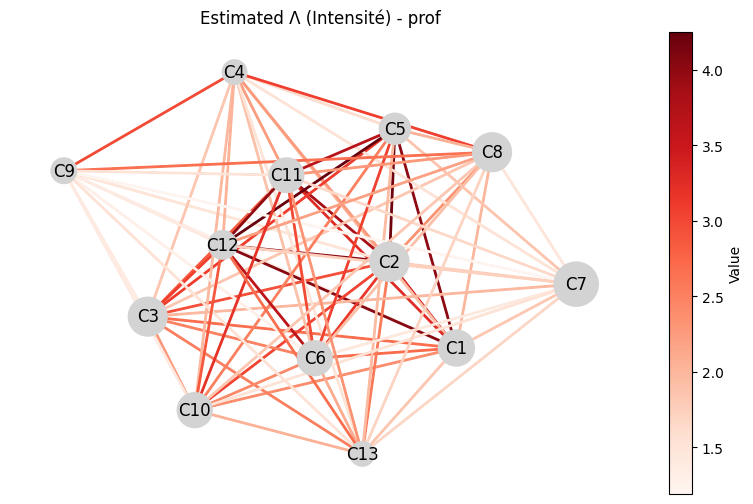

In [62]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Graphes Π/Λ (prof) sur A_prof
cluster_pairs = np.zeros((k, k))
intensity_pairs = np.zeros((k, k))
count_pairs = np.zeros((k, k))

n_model = min(len(clusters), A_prof.shape[0])
for i in range(n_model):
    for j in range(i+1, n_model):
        c_i = clusters[i]
        c_j = clusters[j]
        weight = A_prof[i, j]
        cluster_pairs[c_i, c_j] += (weight > 0)
        intensity_pairs[c_i, c_j] += weight
        count_pairs[c_i, c_j] += 1
        cluster_pairs[c_j, c_i] = cluster_pairs[c_i, c_j]
        intensity_pairs[c_j, c_i] = intensity_pairs[c_i, c_j]
        count_pairs[c_j, c_i] = count_pairs[c_i, c_j]

pi_matrix = cluster_pairs / np.maximum(count_pairs, 1)
lambda_matrix = intensity_pairs / np.maximum(count_pairs, 1)

cluster_sizes = np.bincount(clusters, minlength=k)

def draw_cluster_graph(matrix, title, cmap, threshold=0.3, scale_factor=100):
    G = nx.Graph()
    for c in range(k):
        G.add_node(c, size=cluster_sizes[c] * scale_factor, label=f"C{c+1}")

    for c_i in range(k):
        for c_j in range(c_i+1, k):
            value = matrix[c_i, c_j]
            if value > threshold:
                G.add_edge(c_i, c_j, weight=value)

    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[n]['size'] for n in G.nodes]
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
    edge_weights = [d['weight'] for u,v,d in G.edges(data=True)]
    edge_colors = edge_weights

    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(G, pos, ax=ax, node_size=node_sizes, node_color='lightgray', with_labels=False)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=node_labels)
    if len(edge_weights) > 0:
        nx.draw_networkx_edges(G, pos, ax=ax, width=2, edge_color=edge_colors, edge_cmap=cmap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Value')
    ax.set_title(title)
    plt.show()

# Π (probas, threshold 0.3)
draw_cluster_graph(pi_matrix, 'Estimated Π (Probabilités de connexion) - prof', plt.cm.Reds, threshold=0.3, scale_factor=10)
# Λ (intensités, threshold 1)
draw_cluster_graph(lambda_matrix, 'Estimated Λ (Intensité) - prof', plt.cm.Reds, threshold=1, scale_factor=10)
